In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import urllib
import json
import os, glob
%matplotlib notebook

In [2]:
#get path to network folder with lims images for this mouse
mouse_num = '421323'
json_string = urllib.urlopen("http://lims2/specimens/isi_experiment_details/" + mouse_num + ".json").read()
info = json.loads(json_string)
vimg_path = r'\\' + info[0]['target_map_image_path'][1:]
print(vimg_path)

\\allen/programs/braintv/production/visualbehavior/prod0/specimen_769292015/isi_experiment_777042004/777042004_target_map.tif


In [40]:
#get vasculature image
vimg = cv2.imread(vimg_path)

#get probe insertion image
pimgFileName = r'Z:\04252019\2019_04_25_15_42_16_left.png'
pimg = cv2.imread(pimgFileName)

#change from opencv bgr default back to rgb
pimg = pimg[:, :, [2,1,0]]
vimg = vimg[:, :, [2,1,0]]

In [78]:
#class to handle annotating the images with points of interest
#USE: left mouse clicks will draw red dots on image and populate a list of x y coordinates for each dot
#     right mouse clicks will clear the dots and the x y coordinate list
class pointAnnotator:
    def __init__(self, im, ax):
        self.ax = ax
        self.ax.set_xlim([0,im.get_array().shape[1]])
        self.ax.set_ylim([im.get_array().shape[0],0])
        
        self.im = im
        self.xs = []
        self.ys = []
        self.annos = []
        self.labels = []
        self.cid = im.figure.canvas.mpl_connect('button_press_event', self.onclick)
        self.cidrelease = im.figure.canvas.mpl_connect('button_release_event', self.onrelease)
        
        self.kid = im.figure.canvas.mpl_connect('key_press_event', self.keypress)

    def onclick(self, event):
        if event.inaxes==self.ax:
            if event.button == 1:
                print('x ' + str(event.xdata) + '\ty ' + str(event.ydata))
                self.xs.append(event.xdata)
                self.ys.append(event.ydata)

                anno, = self.ax.plot(event.xdata, event.ydata, 'ro')
                self.annos.append(anno)
                lab = self.ax.text(event.xdata+0.2, event.ydata+0.2, str(len(self.annos)))
                self.labels.append(lab)
                self.im.figure.canvas.draw()  
            else:
                self.resetAnnotations()
    def onrelease(self, event):
        #check to see if this was a click and drag, in which case, don't draw point
        if event.inaxes==self.ax:
            distance = ((event.xdata-self.xs[-1])**2 + (event.ydata-self.ys[-1])**2)**0.5
            if distance > 10:
                self.deleteLastAnnotation()
    def keypress(self, event):
        if event.inaxes==self.ax:
            self.deleteLastAnnotation()
    
    def resetAnnotations(self):
        self.xs=[]
        self.ys=[]
        for a, l in zip(self.annos, self.labels):
            a.remove()
            l.remove()
        self.im.figure.canvas.draw()
        self.annos=[]
        self.labels=[]
    
    def deleteLastAnnotation(self):
        self.xs = self.xs[:-1]
        self.ys = self.ys[:-1]
        self.annos[-1].remove()
        self.labels[-1].remove()
        self.annos = self.annos[:-1]
        self.labels = self.labels[:-1]
        self.im.figure.canvas.draw()
    
    def loadPoints(self, points):
        self.xs = list(points[:, 0])
        self.ys = list(points[:, 1])
        self.drawPoints()
        
    def drawPoints(self):
        for i, (x,y) in enumerate(zip(self.xs, self.ys)):
            anno, = self.ax.plot(x,y, 'ro')
            self.annos.append(anno)
            lab = self.ax.text(x,y,str(i+1))
            self.labels.append(lab)
            self.im.figure.canvas.draw()

<IPython.core.display.Javascript object>


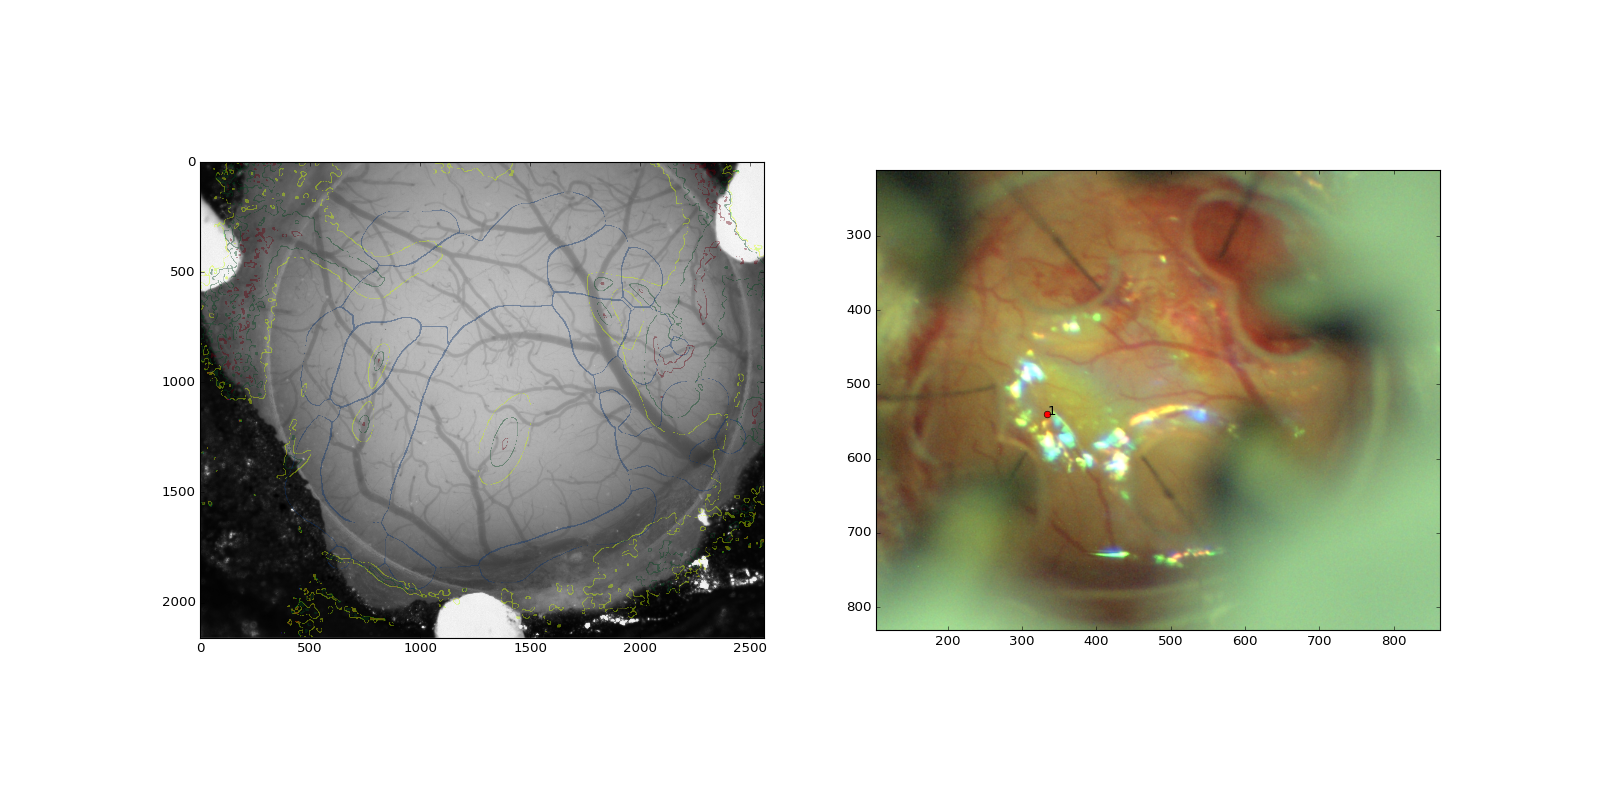

In [79]:
#Display the vasculature image and select points of interest (at least three)
fig, ax = plt.subplots(1,2, figsize=(20,10))
vax = ax[0]
pax = ax[1]

vim = vax.imshow(vimg, origin='upper')
vpa = pointAnnotator(vim, vax)
vpa.loadPoints(vpoints)

pim = pax.imshow(pimg, origin='upper')
ppa = pointAnnotator(pim, pax)



In [58]:
print(vpa.xs)
print(ppa.xs)

[1029.909097782258]
[193.16530157930129]


<IPython.core.display.Javascript object>


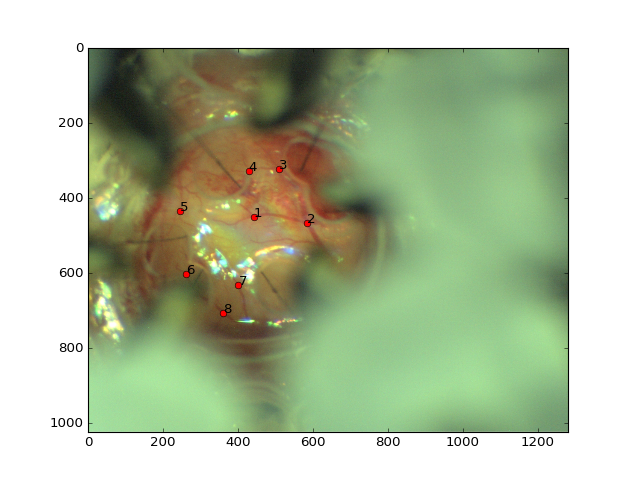

In [72]:
#Display the probe insertion image and click the matching points from the vasuclature image (must be in same order)
pfig, pax = plt.subplots()
pim = pax.imshow(pimg, origin='upper')
ppa = pointAnnotator(pim, pax)
ppa.loadPoints(ppoints)

In [73]:
print(ppa.xs)

[442.1643  585.2353  510.29333 428.53848 244.5901  260.48688 401.28687
 360.40945]


[[442.1643  451.81937]
 [585.2353  467.71613]
 [510.29333 322.3742 ]
 [428.53848 326.91614]
 [244.5901  433.6516 ]
 [260.48688 601.70325]
 [401.28687 631.2258 ]
 [360.40945 706.1677 ]
 [246.86107 374.60645]
 [551.1708  519.94836]]
[[1353.5     795.9375]
 [1831.625   840.9375]
 [1567.25    300.9375]
 [1286.      289.6875]
 [ 571.625   632.8125]
 [ 695.375  1313.4375]
 [1246.625  1442.8125]
 [ 982.25   1628.4375]
 [ 554.75    413.4375]
 [1747.25   1037.8125]]


<IPython.core.display.Javascript object>


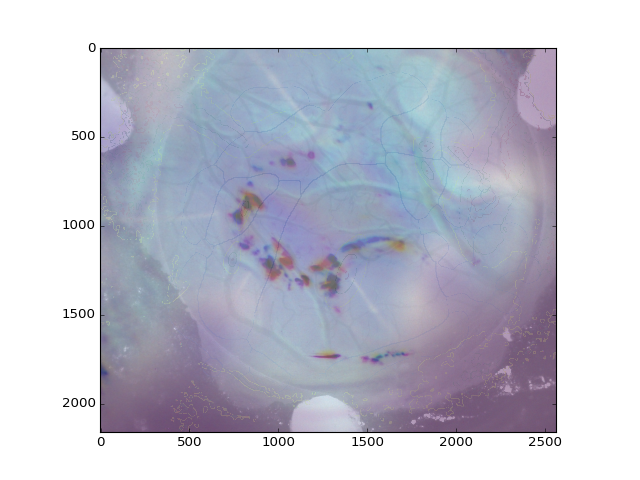

In [62]:
#Compute affine transform to warp probe insertion image to vasculature image coordinates
ppoints = np.stack((ppa.xs, ppa.ys)).astype(np.float32).T
vpoints = np.stack((vpa.xs, vpa.ys)).astype(np.float32).T
print(ppoints)
print(vpoints)
#aff = cv2.estimateRigidTransform(ppoints, vpoints, False)
#pimg_aff = cv2.warpAffine(pimg, aff, (vimg.shape[1], vimg.shape[0]))
#perspective = cv2.getPerspectiveTransform(ppoints,vpoints)
perspective = cv2.findHomography(ppoints, vpoints)
pimg_aff = cv2.warpPerspective(pimg, perspective[0], (vimg.shape[1], vimg.shape[0]))

fig, ax = plt.subplots()
ax.imshow(vimg, alpha=0.5)
ax.imshow(255-pimg_aff, alpha=0.5)
# p_green = np.squeeze(pimg_aff[:, :, 1])
# im = ax.imshow(vimg[:, :, 1], cmap='Blues', alpha=0.5)
# ax.imshow(255-p_green, cmap='Reds', alpha=0.5)

# array = im.get_array()
# #im2 = ax.imshow(vimg, alpha=0.4)
# @interact(high=[0, 1, 0.01], low=[0,1,0.01])
# def imshow_contrast(high=1, low=0.5):
#     vimg_c = np.copy(array)
#     vimg_c[vimg_c>high*vimg_c.max()] = 255
#     vimg_c[vimg_c<low*vimg_c.max()] = 0
    
#     im.set_array(vimg_c)
    
#     display(fig)


<IPython.core.display.Javascript object>


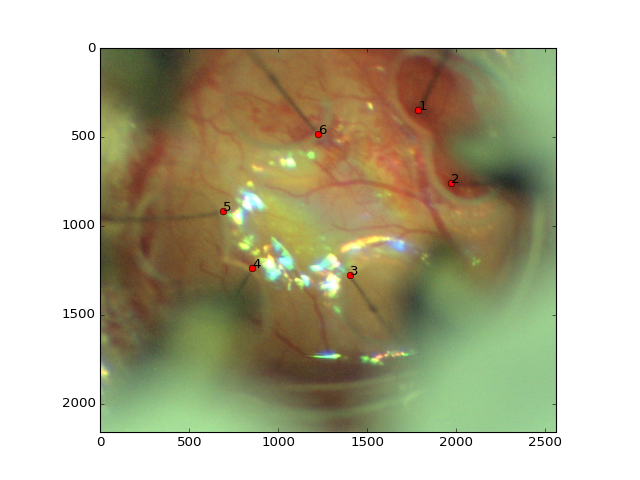

In [63]:
#Select location of probe insertion points in this warped image
paffFig, paffax = plt.subplots()
paff_im = paffax.imshow(pimg_aff, origin='upper')
paffp = pointAnnotator(paff_im, paffax)

<IPython.core.display.Javascript object>


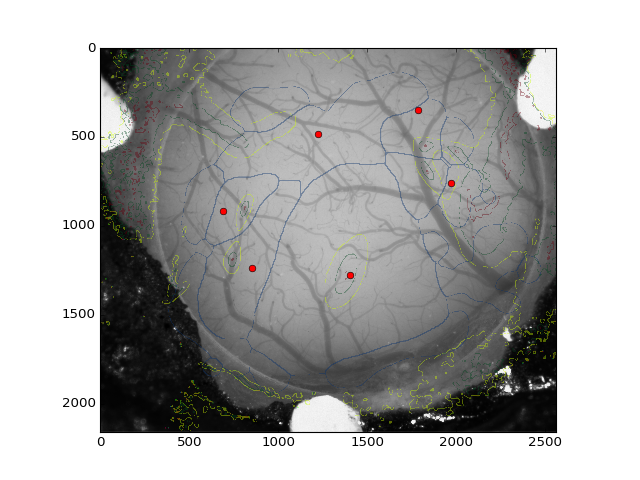

In [64]:
#Plot probe insertion points on vasculature image to double check that it looks reasonable
paffpoints = np.stack((paffp.xs, paffp.ys)).astype(np.float32).T
fig, ax = plt.subplots()
ax.imshow(vimg, origin='upper')
ax.set_xlim([0, vimg.shape[1]])
ax.set_ylim([vimg.shape[0], 0])
for p in paffpoints:
    ax.plot(p[0], p[1], 'ro')

In [43]:
# save points and transformation matrix
saveDirectory = os.path.dirname(pimgFileName)
np.save(os.path.join(saveDirectory,'vasculaturePoints.npy'), vpoints)
np.save(os.path.join(saveDirectory,'probeInsertionPoints.npy'), ppoints)
np.save(os.path.join(saveDirectory, 'vasculatureToProbeInsertionTransform.npy'), perspective[0])